# Transfer Learning with VGG16
**Fine-tuning** is related with Transfer Learning [intuitive understanding](https://youtu.be/5T-iXNNiwIs?list=PLZbbT5o_s2xq7LwI2y8_QtvuXZedL6tQU&t=12). A typical procedure to do this -
- Remove the last layer.
- Freeze the (weights of) other layers.
- Add one (classification) or more (fully connected & classification) layers.

WHAT DID I LEARN TODAY?
1. plotting images from pytorch trainloader can be cumbersome. Better to do it before using trainloader.
2. Not a good idea to use jupyter notebook to call the model multiple times (use separate .py scripts instead) Probably it's the reason for yielding erroneuos results (e.g. 0% accuracy & huge loss value). I couldn't debug the error here, still! 
3. Loss can be more than 1 while classification involves more than 2 classes.
4. https://medium.com/machine-learning-world/how-to-debug-neural-networks-manual-dc2a200f10f2
5. https://towardsdatascience.com/checklist-for-debugging-neural-networks-d8b2a9434f21
6. https://github.com/suriyadeepan/torchtest, https://thenerdstation.medium.com/how-to-unit-test-machine-learning-code-57cf6fd81765
7. [Neural network always predicts the same class](https://stackoverflow.com/a/41493375)
8. [Effective Training and Debugging of a Neural Networks](https://udibhaskar.github.io/practical-ml/debugging%20nn/neural%20network/overfit/underfit/2020/02/03/Effective_Training_and_Debugging_of_a_Neural_Networks.html)
9. https://towardsdatascience.com/debugging-neural-networks-abdc6273a3f1
10. [Debugging neural networks](https://medium.com/analytics-vidhya/debugging-neural-networks-96d3421e9646)

## Table of contents
- [Imports](#imports)
- [Set device](#device)
- [Hyperparameters](#hyperparameters)
- [Load CIFAR-10 Data](#dataloader)
- [VGG16 Architecture](#architecture)
    - [VGG16 Architecture](#architecturePretrained)
    - [Modifying architecture](#modifyingArchitecture)
- [Loss and Optimizer](#lossandoptim) 
- [Check Accuracy](#checkAccuracy)
- [Train Network](#training)
    - [Trainer Class](#trainerClass)
    - [Run 1](#run1)
    - [Collating alltogether](#collatingTogether)
    - [Run 1a](#run1a)
    - [Run 2](#run2)
    - [Run 3](#run3)
- [References](#references)

## <a name="imports"></a> Imports

In [16]:
import torch #PyTorch Framework
from torch import nn as nn #for nn.Linear,nn.Conv2d,
import torch.optim as optim #optimization algortihms (Adam, SGD, etc.)
from torch.utils.data import DataLoader #easier data handling, batch processing etc.
import torchvision
from torchvision import datasets as ds #downloadable source of standard datasets
from torchvision import transforms as T #various image transforms

import matplotlib.pyplot as plt
from torchsummary import summary

#!pip install tqdm
from tqdm import tqdm #progress bar

import tensorflow as tf
import tensorboard as tb
from torch.utils.tensorboard import SummaryWriter

## Tensorboard

In [17]:
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
writer = SummaryWriter('../../runs/VGG16_TransferLearning/')

## <a name="device"></a> Set device

In [18]:
import platform
print(platform.platform())
torch.has_mps #M1 Mac GPU implementation: mps
device = torch.device("mps" if torch.has_mps else "cpu") #M1 Mac
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #cuda
# device = "cpu"

macOS-13.2.1-arm64-arm-64bit


## <a name="hyperparameters"></a> Hyperparameters

In [19]:
inChannel = 3
N_classes = 10
learningRate = 1e-5 #1e-3
batchSize = 1000
N_epochs = 2 #5 

## <a name="dataloader"></a> Load CIFAR-10 Data

In [20]:
train_ds = ds.CIFAR10(root ='../../data/', train=True, download=True, transform=T.ToTensor())
train_loader = DataLoader(dataset=train_ds, batch_size=batchSize, shuffle=True)
test_ds = ds.CIFAR10(root ='../../data/', train=False, download=True, transform=T.ToTensor())
test_loader = DataLoader(dataset=test_ds, batch_size=batchSize, shuffle=None)
print(train_loader.dataset, "\n", test_loader.dataset)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../../data/
    Split: Train
    StandardTransform
Transform: ToTensor() 
 Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../../data/
    Split: Test
    StandardTransform
Transform: ToTensor()


### <a name="plotdata"></a> Check dataset

[0 1 2 3 4 5 6 7 8 9]
torch.Size([1000, 3, 32, 32])


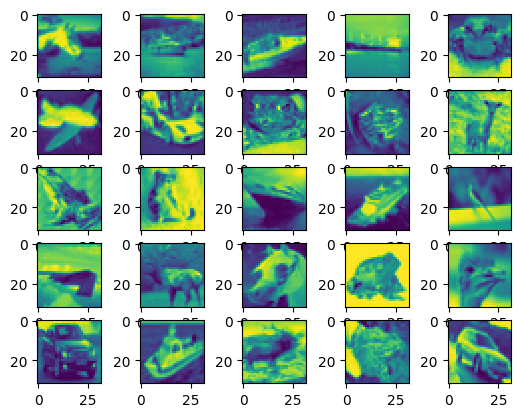

In [21]:
example_data, example_targets = next(iter(train_loader)) # previously `examples.next()`
print(np.unique(example_targets)) #number of labels/ targets
print(example_data.shape) #example_data[4999][0].shape #returns shape of one batch
# plt.axis('off')
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(example_data[i][0])#, cmap=(0,155,3))
# plt.show()

## <a name="architecture"></a> VGG16 Architecture
### <a name="architecturePretrained"></a> Load & check Pretrained VGG16 from `torchvision`

In [22]:
model = torchvision.models.vgg16(
                                # weights=None, #no weights from the pretrained model.
                                weights="DEFAULT",
                                #  weights='VGG16_Weights.DEFAULT', #The parameter 'pretrained' is 
# deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
                                )
print(model)
summary(model, (3, 32, 32), batch_size=batchSize)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### <a name="modifyingArchitecture"></a> Modifying Architecture
[]()

With CIFAR-10, - 
 1. the `avgpool` will yield 1x1 `ouput_size`.
 2. classes (`out_features`) will be 10 in stead of 1000.

In [23]:
# class Identify(nn.Module): # this allows to flow the nn without any modification
#     def __init__(self):
#         super(Identify, self).__init__()
        
#     def forward(self, x):
#         return x
    
model = torchvision.models.vgg16(weights="DEFAULT")#.to(device)
model.avgpool = nn.Identity()
# model.classifier = nn.Linear(512, 10)
model.classifier = nn.Sequential(nn.Linear(512, 100), nn.ReLU(), nn.Linear(100, N_classes))
# model = torch.compile(model)
print(model)
summary(model, (3, 32, 32), batch_size=batchSize)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## <a name="lossandoptim"></a>  Loss and Optimizer

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learningRate)

## Train Network

In [25]:
# @torch.compile
def modelTrainer(model=torchvision.models.vgg16(weights="DEFAULT")):
# def modelTrainer(X):
    # model=torchvision.models.vgg16(weights="DEFAULT")
    print(model.classifier)
    # model = torch.compile(model)
    model = model.to(device)
    for epoch in range(N_epochs):
        losses = []
        for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
            data = data.to(device)
            targets = targets.to(device)
# Forward PASS
            scores = model(data)
            loss = criterion(scores, targets)
            losses.append(loss.item())
# Backward PASS       
            optimizer.zero_grad()
            loss.backward()
# gradient descent or adam step            
            optimizer.step()
        print(f"Cost at epoch {epoch} is {sum(losses)/len(losses):.5f}")

## <a name="checkAccuracy"></a> Check Accuracy

In [26]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f"Got {num_correct} / {num_samples} with accuracy\
            {float(num_correct)/float(num_samples)*100:.2f}")

## <a name="graph"></a> Tensorboard Graph

In [27]:
############## TENSORBOARD ########################
# img_grid = torchvision.utils.make_grid(example_data.to("cpu"))
# writer.add_image('mnist_images', img_grid)
# writer.close()
#sys.exit()
###################################################

############## TENSORBOARD ########################
# example_data.shape
writer.add_graph(model.to("cpu"), example_data)#.to(device)
writer.close()
# sys.exit()
###################################################

## <a name="training"></a> Train Network
### <a name="trainerClass"></a> Trainer Class

In [28]:
%load_ext tensorboard
#%tensorboard --logdir ("runs")#/MNIST/MiniBatchSize {batch_size} LR {learning_rate}")
%tensorboard --logdir ../../runs/VGG16_TransferLearning/ #logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

### <a name="run2"></a> Run 2: 
As expected, without any pretrained weight, we got poor accuracy (< 20%) with low number of epochs (5). 
- With pretrained weights, 
- Only the last layers (avgpool & classifier) are changed.

In [29]:
# model = torchvision.models.vgg16(weights="DEFAULT")
# torch._dynamo.config.suppress_errors = True
# model = torch.compile(model)
modelTrainer(model)
check_accuracy(train_loader,model)
check_accuracy(test_loader, model)

Sequential(
  (0): Linear(in_features=512, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=10, bias=True)
)


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


Cost at epoch 0 is 2.04240


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


Cost at epoch 1 is 1.09630
Checking accuracy on training data
Got 34902 / 50000 with accuracy            69.80
Checking accuracy on test data
Got 6899 / 10000 with accuracy            68.99


In [30]:
# del(model)
model = torchvision.models.vgg16(weights='DEFAULT')
modelTrainer(model)
check_accuracy(train_loader,model)
check_accuracy(test_loader, model)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


Cost at epoch 0 is 15.21429


100%|██████████| 50/50 [00:58<00:00,  1.18s/it]


Cost at epoch 1 is 15.20464
Checking accuracy on training data
Got 76 / 50000 with accuracy            0.15
Checking accuracy on test data
Got 9 / 10000 with accuracy            0.09


### <a name="run1"></a> Run 1: 
- No pretrained weights, 
- Only the last layers (avgpool & classifier) are changed.


In [ ]:
model = torchvision.models.vgg16(weights=None) 
model.to(device)
modelTrainer(model)
check_accuracy(train_loader,model)
check_accuracy(test_loader, model)


modelTrainer.__mro__

In [ ]:

# model = torchvision.models.vgg16(
#                                 # weights=None
#                                 # weights="None" doesn't work
#                                 # weights="VGG16_Weights.DEFAULT" epoch 0 cost 15
#                                 # weights='DEFAULT' epoch 0 cost 15.22019
#                                 # weights="DEFAULT" epoch 0 cost 15.21923
#                                 weights="DEFAULT"
#                                 # weights="VGG16_Weights.DEFAULT"
#                                 )
modelTrainer(model)
check_accuracy(train_loader,model)
# check_accuracy(test_loader, model)

### <a name="run3"></a> Run 3: 
- With pretrained weights, 
- Only the last layers (avgpool & classifier) are changed.

In [ ]:
model = torchvision.models.vgg16(weights=None, #no weights from the pretrained model.
                                 # 'VGG16_Weights.DEFAULT', #The parameter 'pretrained' is 
# deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
                                 progress=True) 
modelTrainer(model, req_grad=False)
print(model)
check_accuracy(train_loader,model)
# check_accuracy(test_loader, model)

# <a name="references"></a> References
- []()
- [Pytorch Tutorial 15 - Transfer Learning](https://youtu.be/K0lWSB2QoIQ?list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&t=99)
-

In [ ]:
import numpy as np #general math operations
import torch #PyTorch Framework
from torch import nn as nn #for nn.Linear,nn.Conv2d,
import torch.nn.functional as F
import torch.optim as optim #optimization algortihms (Adam, SGD, etc.)
from torch.utils.data import DataLoader #easier data handling, batch processing etc.
import torchvision
from torchvision import datasets as ds #downloadable source of standard datasets
from torchvision import transforms as T #various image transforms

import matplotlib.pyplot as plt
from torchsummary import summary

#!pip install tqdm
from tqdm import tqdm #progress bar

import tensorflow as tf
import tensorboard as tb
from torch.utils.tensorboard import SummaryWriter

import platform
print(platform.platform())
torch.has_mps #M1 Mac GPU implementation: mps
device = torch.device("mps" if torch.has_mps else "cpu") #M1 Mac
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #cuda
# device = "cpu"

inChannel = 3
N_classes = 10
learningRate = 1e-3 #1e-3
batchSize = 1000
N_epochs = 5

train_ds = ds.CIFAR10(root ='../../data/', train=True, download=True, transform=T.ToTensor())
train_loader = DataLoader(dataset=train_ds, batch_size=batchSize, shuffle=True)
test_ds = ds.CIFAR10(root ='../../data/', train=False, download=True, transform=T.ToTensor())
test_loader = DataLoader(dataset=test_ds, batch_size=batchSize, shuffle=None)
print(train_loader.dataset, "\n", test_loader.dataset)

model = torchvision.models.vgg16(pretrained=False)
model.avgpool = nn.Identity()
model.classifier = nn.Sequential(nn.Linear(512, 100), nn.ReLU(), nn.Linear(100, N_classes))
print(model)
summary(model, (3, 32, 32), batch_size=batchSize)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learningRate)

def modelTrainer(model):
    model=model.to(device)
    for epoch in range(N_epochs):
        losses = []
        for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
            data = data.to(device)
            targets = targets.to(device)
            # Forward PASS
            scores = model(data)
            loss = criterion(scores, targets)
            losses.append(loss.item())
            # Backward PASS       
            optimizer.zero_grad()
            loss.backward()
            # gradient descent or adam step            
            optimizer.step()
        print(f"Cost at epoch {epoch} is {sum(losses)/len(losses):.5f}")


def check_accuracy(loader, model):
    if loader.dataset.train:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f"Got {num_correct} / {num_samples} with accuracy\
            {float(num_correct)/float(num_samples)*100:.2f}")
        


In [ ]:
model = torchvision.models.vgg16(weights='DEFAULT')
modelTrainer(model)
check_accuracy(train_loader,model)
check_accuracy(test_loader, model)